# Selección de modelo

# Definiciones

In [1]:
# Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

# Cargar datos

In [3]:
# Cargar datos ya preprocesados y dividirlos en variables independientes (X) y variable dependiente objetivo (Y)

archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados = pd.read_csv(archivo_datos_codificados, low_memory=False)

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

print('\nVariables de entrada (X):')
print(f'{len(X.columns)} columnas:\n{X.columns.to_list()}')
print('-' * 92)
print('\nVariable dependiente (Y):')
print(Y.info())
print(Y.value_counts().sort_index())


Variables de entrada (X):
20 columnas:
['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'ARRANQUE', 'ZONA_SUR', 'MUNICIPIO_MEDELLIN', 'ESTADO_OPERACION', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS']
--------------------------------------------------------------------------------------------

Variable dependiente (Y):
<class 'pandas.core.series.Series'>
RangeIndex: 25674 entries, 0 to 25673
Series name: DETERIORADO
Non-Null Count  Dtype
--------------  -----
25674 non-null  bool 
dtypes: bool(1)
memory usage: 25.2 KB
None
DETERIORADO
False    14246
True     11428
Name: count, dtype: int64


# Verificar balance de variable dependiente

Balance=80.22%, Proporción=1.25, ajuste_prob=30.22%


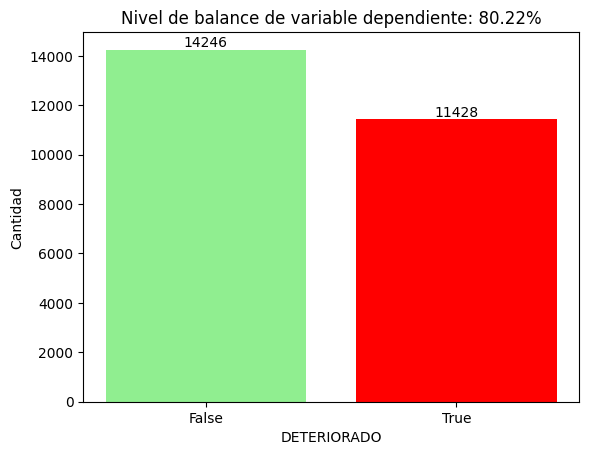

In [5]:
conteo = Y.value_counts()
balance = (min(conteo) / max(conteo))
proporcion = max(conteo) / min(conteo)
ajuste_prob = .5 - (1 - balance)
print(f'Balance={balance:.2%}, Proporción={proporcion:.2f}, ajuste_prob={ajuste_prob:.2%}')

plt.bar(conteo.index.astype(str), conteo.values, color=['lightgreen', 'red'])
for i, valor in enumerate(conteo.values):
    plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom')

plt.xlabel('DETERIORADO')
plt.ylabel('Cantidad')
plt.title(f'Nivel de balance de variable dependiente: {balance:.2%}')
plt.show()

# Crear estructuras para almacenar modelos y sus resultados

In [6]:
# Definir clase para evaluación de modelos
class EvaluacionModeloML:
    def __init__(self, modelo, param_grid={}):
        self.isTrained = False
        self.modelo = modelo
        self.param_grid = param_grid
        self.best_params = {}
        self.scoresCV = None # Para resultados de cross_validate

# Inicializar diccionario de evaluaciones
dict_evaluaciones = {}

# Rango de balance de clases
class_weights_list = [
    {False: 1,               True: (1 + ajuste_prob)}, 
    {False: (1-ajuste_prob), True: 1},
    {False: 1, True: proporcion},
]

# Configurar modelos candidatos

### Logistic Regression

In [7]:
dict_evaluaciones['LGR'] = EvaluacionModeloML(
    modelo = LogisticRegression(),
    param_grid = {
        'C'                      : [2 ],
        'class_weight'           : [class_weights_list[1]],
        #'dual'                   : [False, ],
        #'fit_intercept'          : [True, False, ],
        #'intercept_scaling'      : [1, 0.1, 10, ],
        #'l1_ratio'               : [None, ],
        #'max_iter'               : [100, 1000 ],
        #'multi_class'            : ['auto', ],
        'n_jobs'                 : [-1],
        #'penalty'                : ['l2', None],
        'solver'                 : ['newton-cholesky'],
        #'tol'                    : [0.0001, 1e-05, 0.001, ],
        #'warm_start'             : [True, False],
    }
)

### Histogram-based Gradient Boosting Classification Tree

In [8]:
dict_evaluaciones['HGBC'] = EvaluacionModeloML(
    modelo = HistGradientBoostingClassifier(),
    param_grid = {
        # 'categorical_features'   : ['warn', ],
        'class_weight'           : [class_weights_list[1]],
        # 'class_weight'           : [{False: 1, True: proporcion}],
        # 'interaction_cst'        : [None, ],
        'l2_regularization'      : [1],
        'learning_rate'          : [0.015],
        # 'loss'                   : ['log_loss', ],
         'max_bins'               : [255],
        'max_depth'              : [None],
        # 'max_features'           : [1.0, 0.1, 10.0, ],
        'max_iter'               : [100],
        'max_leaf_nodes'         : [63],
        'min_samples_leaf'       : [5],
        # 'monotonic_cst'          : [None, ],
        'n_iter_no_change'       : [10],
        'scoring'                : ['loss'],
        # 'tol'                    : [1e-07, 1e-08, 1e-06, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        'early_stopping'         : [False],
    }
)

### Multi-layer perceptron Classifier (Red neuronal)

In [9]:
dict_evaluaciones['MLPdefault'] = EvaluacionModeloML(
    modelo = MLPClassifier(),
    param_grid = {
        # 'activation'             : ['tanh'],
        # 'alpha'                  : [0.0001, 1e-05, 0.001, ],
        # 'batch_size'             : ['auto', ],
        # 'beta_1'                 : [0.9, 0.09, 9.0, ],
        # 'beta_2'                 : [0.999, 0.0999, 9.99, ],
        # 'epsilon'                : [1e-08, 1e-09, 1e-07, ],
        #'hidden_layer_sizes'     : [(100,), (100, 100), (32, 64, 32)],
        #'hidden_layer_sizes'     : [(32, 64, 32), (32, 64, 128, 64, 32)],
        # 'hidden_layer_sizes'     : [(32, 64, 32), (64, 128, 64), (128, 128, 128)],
        # 'hidden_layer_sizes'     : [(96, 96, 96, 96)],
        # 'learning_rate'          : ['constant'], #'adaptive', 'invscaling'],
        #  'learning_rate_init'     : [0.0001],
        # 'max_fun'                : [15000, 1500.0, 150000, ],
        # 'max_iter'               : [5000],
        #  'momentum'               : [0.5],
        # 'n_iter_no_change'       : [10, 1.0, 100, ],
        # 'nesterovs_momentum'     : [True, False, ],
        # 'power_t'                : [0.5, 0.05, 5.0, ],
        # 'solver'                 : ['sgd'],
        # 'tol'                    : [0.0001, 1e-05, 0.001, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        # 'warm_start'             : [False],
    }
)

In [10]:
dict_evaluaciones['MLP01'] = EvaluacionModeloML(
    modelo = MLPClassifier(),
    param_grid = {
        'activation'             : ['logistic'],
        #'alpha'                  : [0.0001, 1e-05],
        # 'batch_size'             : ['auto', ],
        # 'beta_1'                 : [0.9, 0.09, 9.0, ],
        # 'beta_2'                 : [0.999, 0.0999, 9.99, ],
        # 'epsilon'                : [1e-08, 1e-09, 1e-07, ],
        'hidden_layer_sizes'     : [(40)],
        #'hidden_layer_sizes'     : [(32, 64, 32), (32, 64, 128, 64, 32)],
        # 'hidden_layer_sizes'     : [(32, 64, 32), (64, 128, 64), (128, 128, 128)],
        # 'hidden_layer_sizes'     : [(96, 96, 96, 96)],
        # 'learning_rate'          : ['constant', 'adaptive', 'invscaling'],
        #'learning_rate_init'     : [0.0001],
        # 'max_fun'                : [15000, 1500.0, 150000, ],
        'max_iter'               : [5000],
        #  'momentum'               : [0.5],
        # 'n_iter_no_change'       : [10, 1.0, 100, ],
        # 'nesterovs_momentum'     : [True, False, ],
        # 'power_t'                : [0.5, 0.05, 5.0, ],
        # 'solver'                 : ['sgd'],
        # 'tol'                    : [0.0001, 1e-05, 0.001, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        # 'warm_start'             : [False],
    }
)

In [11]:
dict_evaluaciones['MLP02'] = EvaluacionModeloML(
    modelo = MLPClassifier(),
    param_grid = {
        'activation'             : ['tanh'],
        'alpha'                  : [0.0001],
        # 'batch_size'             : ['auto', ],
        # 'beta_1'                 : [0.9, 0.09, 9.0, ],
        # 'beta_2'                 : [0.999, 0.0999, 9.99, ],
        # 'epsilon'                : [1e-08, 1e-09, 1e-07, ],
        'hidden_layer_sizes'     : [(40)],
        #'hidden_layer_sizes'     : [(32, 64, 32), (32, 64, 128, 64, 32)],
        # 'hidden_layer_sizes'     : [(32, 64, 32), (64, 128, 64), (128, 128, 128)],
        # 'hidden_layer_sizes'     : [(96, 96, 96, 96)],
        'learning_rate'          : ['constant'],
        'learning_rate_init'     : [0.001],
        # 'max_fun'                : [15000, 1500.0, 150000, ],
        'max_iter'               : [5000],
        #  'momentum'               : [0.5],
        # 'n_iter_no_change'       : [10, 1.0, 100, ],
        # 'nesterovs_momentum'     : [True, False, ],
        # 'power_t'                : [0.5, 0.05, 5.0, ],
        'solver'                 : ['sgd'],
        # 'tol'                    : [0.0001, 1e-05, 0.001, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        # 'warm_start'             : [False],
    }
)

### XGBoost

In [12]:
dict_evaluaciones['XGB01'] = EvaluacionModeloML(
    modelo = XGBClassifier(),
    param_grid = {
        'objective'              : ['binary:logistic'],
        # 'base_score'             : [None, ],
        # 'booster'                : [None, ],
        # 'callbacks'              : [None, ],
        # 'colsample_bylevel'      : [None, ],
        # 'colsample_bynode'       : [None, ],
        # 'colsample_bytree'       : [None, ],
        # 'device'                 : ['gpu'],
        # 'early_stopping_rounds'  : [None, ],
        # 'enable_categorical'     : [False, True, ],
        'eval_metric'            : ['logloss'],
        # 'feature_types'          : [None, ],
        # 'gamma'                  : [None, ],
        # 'grow_policy'            : [None, ],
        # 'importance_type'        : [None, ],
        # 'interaction_constraints': [None, ],
        'learning_rate'          : [0.01],
        # 'max_bin'                : [None, ],
        # 'max_cat_threshold'      : [None, ],
        # 'max_cat_to_onehot'      : [None, ],
        # 'max_delta_step'         : [None, ],
        'max_depth'              : [3],
        # 'max_leaves'             : [None, ],
        'min_child_weight'       : [0.05],
        # 'missing'                : [nan, nan, nan, ],
        # 'monotone_constraints'   : [None, ],
        # 'multi_strategy'         : [None, ],
        # 'n_estimators'           : [None, 500],
        'n_jobs'                 : [-1],
        # 'num_parallel_tree'      : [None, ],
        # 'reg_alpha'              : [0, 1],
        'reg_lambda'             : [10],
        # 'sampling_method'        : [None, ],
        'scale_pos_weight'       : [1+ajuste_prob, 1],
        'subsample'              : [0.5],
        # 'tree_method'            : [None, ],
        # 'validate_parameters'    : [None, ],
        # 'verbosity'              : [None, ],
    }
)

## Valores detectados

In [13]:
dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: 0.6978099115541204, True: 1}, 'early_stopping': False, 'l2_regularization': 1, 'learning_rate': 0.015, 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 63, 'min_samples_leaf': 5, 'n_iter_no_change': 10, 'scoring': 'loss'}
dict_evaluaciones["MLPdefault"].best_params = {'activation': 'relu'}
dict_evaluaciones["MLP01"].best_params = {'activation': 'logistic', 'hidden_layer_sizes': 40, 'max_iter': 5000}
dict_evaluaciones["MLP02"].best_params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 5000, 'solver': 'sgd'}
# dict_evaluaciones["XGB01"].best_params = {'device': 'gpu', 'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 0.05, 'n_jobs': -1, 'objective': 'binary:logistic', 'reg_lambda': 10, 'scale_pos_weight': 1.3021900884458795, 'subsample': 0.5}

## Separación de datos de entrenamiento y validación

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

## Búsqueda de hiperparámetros de cada modelo

In [15]:
SCORER = make_scorer(f1_score)

print('Cálculo de hiperparámetros')
print('-' * 80)
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'\n{nombre}')
    if evaluacion.isTrained:
        print('Ya entrenado.')
    elif evaluacion.best_params == {}: # Recalcular solo si es nuevo
        searchCV = GridSearchCV(
            evaluacion.modelo, evaluacion.param_grid,
            cv=10, 
            scoring=SCORER,
            verbose=5,
            #n_jobs=-1, 
        )
        searchCV.fit(x_train, y_train)
        evaluacion.modelo = searchCV.best_estimator_
        evaluacion.best_params = searchCV.best_params_
    else:
        print('Entrenando modelo con hiperparámetros previamente asignados...')
        evaluacion.modelo.set_params(**evaluacion.best_params)
        evaluacion.modelo.fit(x_train, y_train)

    evaluacion.isTrained = True
    print(f'Modelo:', evaluacion.modelo)
    print(evaluacion.modelo.get_params())
    print('-' * 80)

print(f'\nHiperparámetros calculados.')

Cálculo de hiperparámetros
--------------------------------------------------------------------------------

LGR
Entrenando modelo con hiperparámetros previamente asignados...
Modelo: LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1},
                   n_jobs=-1, solver='newton-cholesky')
{'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cholesky', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
--------------------------------------------------------------------------------

HGBC
Entrenando modelo con hiperparámetros previamente asignados...
Modelo: HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204,
                                             True: 1},
                               early_stopping=False, l2_regularization=1,
     

# Validación cruzada (*cross-validation*)

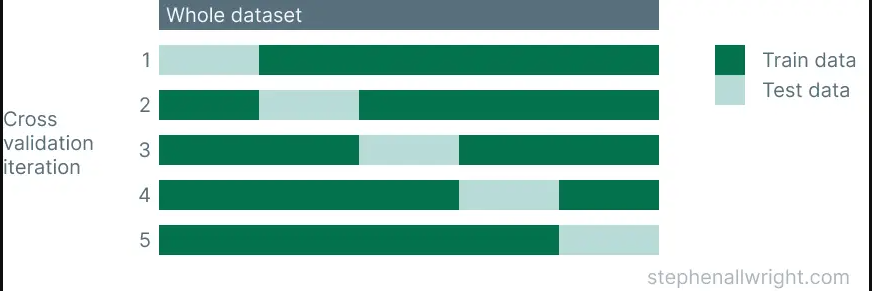

## Evaluación de rendimiento de cada modelo.

In [16]:
print('Rendimiento de cada modelo')
forzar_calculo = False
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'{"-" * 100}')
    print(nombre)
    print(evaluacion.modelo)
    if forzar_calculo | (not evaluacion.scoresCV):
        print('Calculando...')
        evaluacion.scoresCV = cross_validate(
            estimator=evaluacion.modelo,
            X=x_test, y=y_test, 
            cv=10, 
            scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
            verbose=3,
            n_jobs=4,
        )
        print()

    df_scoresCV = pd.DataFrame(evaluacion.scoresCV)
    print(df_scoresCV.mean())

print('-' * 100)
print(f'\n\n** Cross-validation terminado **')

Rendimiento de cada modelo
----------------------------------------------------------------------------------------------------
LGR
LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1},
                   n_jobs=-1, solver='newton-cholesky')
Calculando...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    7.3s remaining:    3.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          0.044374
score_time        0.016939
test_accuracy     0.746223
test_f1           0.739417
test_precision    0.683414
test_recall       0.805860
test_roc_auc      0.811370
dtype: float64
----------------------------------------------------------------------------------------------------
HGBC
HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204,
                                             True: 1},
                               early_stopping=False, l2_regularization=1,
                               learning_rate=0.015, max_leaf_nodes=63,
                               min_samples_leaf=5)
Calculando...


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    4.8s remaining:    2.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          1.977458
score_time        0.042033
test_accuracy     0.752609
test_f1           0.746252
test_precision    0.689353
test_recall       0.813875
test_roc_auc      0.822467
dtype: float64
----------------------------------------------------------------------------------------------------
MLPdefault
MLPClassifier()
Calculando...


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    4.3s remaining:    1.8s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          1.997384
score_time        0.016597
test_accuracy     0.753078
test_f1           0.720054
test_precision    0.729180
test_recall       0.713499
test_roc_auc      0.818241
dtype: float64
----------------------------------------------------------------------------------------------------
MLP01
MLPClassifier(activation='logistic', hidden_layer_sizes=40, max_iter=5000)
Calculando...


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   26.7s remaining:   11.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   37.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          12.566381
score_time         0.018367
test_accuracy      0.754166
test_f1            0.725945
test_precision     0.723667
test_recall        0.729168
test_roc_auc       0.821686
dtype: float64
----------------------------------------------------------------------------------------------------
MLP02
MLPClassifier(activation='tanh', hidden_layer_sizes=40, max_iter=5000,
              solver='sgd')
Calculando...


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    5.8s remaining:    2.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



fit_time          2.494654
score_time        0.013894
test_accuracy     0.751984
test_f1           0.727607
test_precision    0.714352
test_recall       0.742064
test_roc_auc      0.814913
dtype: float64
----------------------------------------------------------------------------------------------------
XGB01
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=0.05, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
   

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished


# Visualizar métricas de modelos

In [17]:
# Generar tabla de métricas

data = {}
model_names = []
for nombre, evaluacion in dict_evaluaciones.items():
    scores = evaluacion.scoresCV
    model_names.append(nombre)
    data[nombre] = [
        scores['test_accuracy'].mean(),
        scores['test_f1'].mean(),
        scores['test_precision'].mean(),
        scores['test_recall'].mean(),
        scores['test_roc_auc'].mean(),        
    ]

df = pd.DataFrame(
    data,
    index=[
        'test_accuracy',
        'test_f1',
        'test_precision',
        'test_recall',
        'test_roc_auc',
    ]
)

df_normalized = pd.DataFrame(df.T, columns=df.index)

In [18]:
# Visualizar tabla

df_tabla_metricas = df_normalized.reset_index()
df_tabla_metricas.rename(
    columns={
        'index'          : 'MODELO',
        'test_accuracy'  : 'ACCURACY',
        'test_f1'        : 'F1',
        'test_precision' : 'PRECISION',
        'test_recall'    : 'RECALL',
        'test_roc_auc'   : 'ROC_AUC',
    },
    inplace=True,
)

#print(df_tabla_metricas[df_tabla_metricas['MODELO'] == 'RFC'])
print(f'Resultados de optimización por {SCORER}')
print('-' * 80)
print(df_tabla_metricas)

Resultados de optimización por make_scorer(f1_score, response_method='predict')
--------------------------------------------------------------------------------
       MODELO  ACCURACY        F1  PRECISION    RECALL   ROC_AUC
0         LGR  0.746223  0.739417   0.683414  0.805860  0.811370
1        HGBC  0.752609  0.746252   0.689353  0.813875  0.822467
2  MLPdefault  0.753078  0.720054   0.729180  0.713499  0.818241
3       MLP01  0.754166  0.725945   0.723667  0.729168  0.821686
4       MLP02  0.751984  0.727607   0.714352  0.742064  0.814913
5       XGB01  0.752923  0.745483   0.691045  0.809689  0.820250


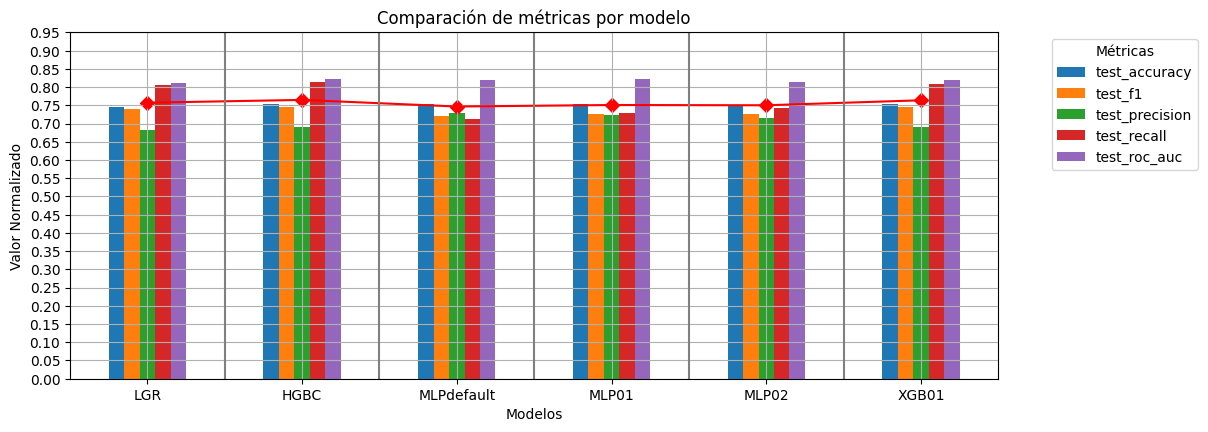

In [19]:
# Visualizar gráfico de barras comparativo

ax = df_normalized.plot(kind='bar', figsize=(13, 4))
ax.set_xticklabels(model_names, rotation=0, ha="center")

legend = ax.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75)

averages = df_normalized.mean(axis=1)

for i, avg in enumerate(averages):
    plt.scatter(i, avg, marker='D', color='red', s=50)

# Primedio
plt.plot(averages.index, averages.values, marker='o', linestyle='-', color='red')
for i in range(1, len(model_names)):
    plt.axvline(x=i-0.5, color='gray', linestyle='-')

plt.yticks(np.arange(0, 1, 0.05))
plt.title('Comparación de métricas por modelo')
plt.xlabel('Modelos')
plt.ylabel('Valor Normalizado')
plt.grid()
plt.show()


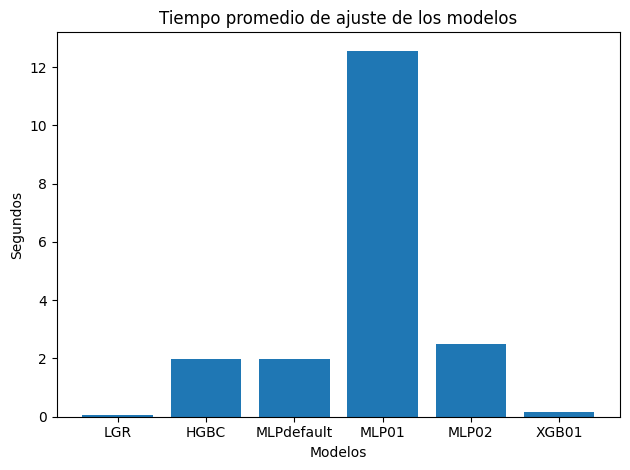

In [20]:
# Visualizar tiempos de ajuste

tiempos = [evaluacion.scoresCV['fit_time'].mean() for evaluacion in dict_evaluaciones.values()]
nombres = dict_evaluaciones.keys()

plt.bar(range(len(nombres)), tiempos)
plt.xticks(range(len(nombres)), nombres)
plt.xlabel('Modelos')
plt.ylabel('Segundos')
plt.title('Tiempo promedio de ajuste de los modelos')
plt.tight_layout()
plt.show()

# Hiperparámetros finales

In [21]:
print('#', '-' * 80)
print(f'# Resultados de optimización por {SCORER}')
print(f'# Factor de ajuste de pesos: {ajuste_prob}')
for linea in df_tabla_metricas.to_string(index=False).split('\n'):
    print(f'# {linea}')
    
print('#', '-' * 80)

for nombre, evaluacion in dict_evaluaciones.items():
    modelo_str = ' '.join([linea.strip() for linea in repr(evaluacion.modelo).split('\n')])
    print(f'# {modelo_str}')
    #print(f'# Full parameters = {evaluacion.modelo.get_params()}')

print('#', '-' * 80)

for nombre, evaluacion in dict_evaluaciones.items():
    print(f'# dict_evaluaciones["{nombre}"].best_params = {evaluacion.best_params}')
    #print('\n#', '-' * 80)


# --------------------------------------------------------------------------------
# Resultados de optimización por make_scorer(f1_score, response_method='predict')
# Factor de ajuste de pesos: 0.3021900884458796
#     MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#        LGR  0.746223 0.739417   0.683414 0.805860 0.811370
#       HGBC  0.752609 0.746252   0.689353 0.813875 0.822467
# MLPdefault  0.753078 0.720054   0.729180 0.713499 0.818241
#      MLP01  0.754166 0.725945   0.723667 0.729168 0.821686
#      MLP02  0.751984 0.727607   0.714352 0.742064 0.814913
#      XGB01  0.752923 0.745483   0.691045 0.809689 0.820250
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1}, early_stopping=False, l2_regularization=1, learning_rate=0.015, max_leaf_nodes=